In [1]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys
sys.path.append('../external/Transformer_modules/')
sys.path.append('../src/')
from modules import MultiHeadAttention, PositionwiseFeedForward
import mnist

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
x_train = mnist.make_clouds(mnist.x_train,500) 
y_train = mnist.y_train
x_val = mnist.make_clouds(mnist.x_val,500) 
y_val = mnist.y_val

In [3]:
class GlobalAveragePooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.mean(dim=self.dim)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, 
                 hidden_dim=100,
                 ffn_dim =200,
                 n_head=8,
                 normalize_loc=True,
                 normalize_scale=True):
        super(Discriminator, self).__init__()
        self.normalize_loc = normalize_loc
        self.normalize_scale = normalize_scale
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.mha_1 = MultiHeadAttention(n_head=n_head,d_model = hidden_dim)
        self.ffn_1 = PositionwiseFeedForward(hidden_dim, ffn_dim, use_residual=False)
        self.mha_2 = MultiHeadAttention(n_head=n_head,d_model = hidden_dim)
        self.ffn_2 = PositionwiseFeedForward(hidden_dim, ffn_dim, use_residual=False)
        
        self.gl_1 =  GlobalAveragePooling(dim = 1)
        
        self.fc2 = nn.Linear(hidden_dim, 2)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
    def forward(self, x):
        if self.normalize_loc:
            x = x - x.mean(dim=1, keepdim=True)
        if self.normalize_scale:
            x = x / x.std(dim=1, keepdim=True)
        
        h1 = F.relu(self.fc1(x))
        h2 = self.mha_1(h1)
        h3 = self.ffn_1(h2)
        h4 = self.mha_2(h3)
        h5 = self.ffn_2(h4)
        score = self.fc2(self.gl_1(h5))
        return score
        

In [5]:
class Generator(nn.Module):
    def __init__(self, in_dim, hidden_dim=100,ffn_dim =200,n_head=8):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.mha_1 = MultiHeadAttention(n_head=n_head,d_model = hidden_dim)
        self.ffn_1 = PositionwiseFeedForward(hidden_dim, ffn_dim, use_residual=False)
        self.mha_2 = MultiHeadAttention(n_head=n_head,d_model = hidden_dim)
        self.ffn_2 = PositionwiseFeedForward(hidden_dim, ffn_dim, use_residual=False)
        self.mha_3 = MultiHeadAttention(n_head=n_head,d_model = hidden_dim)
        self.ffn_3 = PositionwiseFeedForward(hidden_dim, ffn_dim, use_residual=False)

        
        self.fc2 = nn.Linear(hidden_dim, in_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = self.mha_1(h)
        h = self.ffn_1(h)
        h = self.mha_2(h)
        h = self.ffn_2(h)
        h = self.mha_3(h)
        h = self.ffn_3(h)
        score = self.fc2(h)
        return score
        

In [6]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [7]:
in_dim = 2
hidden_dim = 100
ffn_dim = 200
n_head = 8

disc = Discriminator(in_dim, hidden_dim).cuda(1)

In [8]:
in_dim = 2
hidden_dim = 64
ffn_dim = 128
n_head = 8

gen = Generator(in_dim, hidden_dim).cuda(1)

In [9]:
# y_train = y_train.detach().numpy()
x_train = x_train[y_train==5]
y_train = y_train[y_train==5]


In [16]:
# gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-4)
gen_opt = torch.optim.SGD(gen.parameters(), lr=1e-6)
disc_opt = torch.optim.SGD(disc.parameters(), lr=0.001)

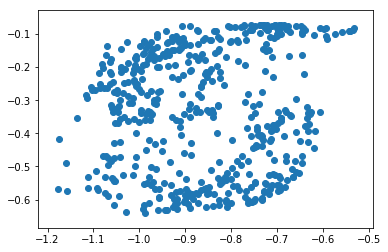

tensor([ 0.7944,  0.2056], device='cuda:1')


In [ ]:
from IPython.display import clear_output
from tqdm import trange
import matplotlib.pyplot as plt
%matplotlib inline
IS_FAKE, IS_REAL = 0, 1
# noise =  torch.rand(target.shape).cuda(1)
for epoch_i in trange(1000):
    for j,(x_tr,y_tr) in enumerate(iterate_minibatches(x_train,y_train,batchsize=50)):
        target = Variable(torch.FloatTensor(x_tr)).cuda(1)
        for i in range(10):
            noise =  torch.rand(target.shape).cuda(1)
            gen_data =   gen(noise)

            loss_disc = - F.log_softmax(disc(target), 1)[:, IS_REAL].mean() \
                        - F.log_softmax(disc(gen_data), 1)[:, IS_FAKE].mean()

            disc_opt.zero_grad()
            loss_disc.backward()
            disc_opt.step()


        for i in range(1):
            noise =  torch.rand(target.shape).cuda(1)
            gen_data =   gen(noise)

            loss_gen = - F.log_softmax(disc(gen_data), 1)[:, IS_REAL].mean()
            gen_opt.zero_grad()
            loss_gen.backward()
            gen_opt.step()
    
        if j % 2 != 0: continue
        noise =  torch.rand(target.shape).cuda(1)
        gen_data =   gen(noise)
        clear_output(True)
        _x, _y = gen_data[:1].data.cpu().numpy()[0].T
        plt.scatter(_x, -_y)

        plt.show()
        print(torch.mean(F.softmax(disc(gen_data), 1),0))
